<a href="https://colab.research.google.com/github/Agewerc/wildlifeComputerVision/blob/master/wild_animal_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional Neural Networks

## An Algorithm for Wildlife Identification 

---
In this notebook we make use of Convolutional Neural Networks to classify animals from the 

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.


First we need to mount the drive with the data.

In [43]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/oregon_wildlife'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import Libraries

In [82]:
import numpy as np
from glob import glob
# Imports
import torch
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import torchvision
import os
import pandas as pd
from skimage import io
from torch.utils.data import (Dataset, DataLoader, )  # Gives easier dataset managment and creates mini batches
from torchvision.datasets import ImageFolder 
import pandas as pd
import os
import re
from sklearn.preprocessing import LabelEncoder
import random 
from PIL import Image 


# Visualize the data

In [45]:
# load filenames for human and dog images
bald_eagle = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/bald_eagle/*"))
black_bear = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/black_bear/*"))
bob_cat = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/bobcat/*"))
canada_lynx = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/canada_lynx/*"))
columbian_black_tailed_deer = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/columbian_black-tailed_deer/*"))
cougar = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/cougar/*"))
coyote = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/coyote/*"))
deer = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/deer/*"))
elk = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/elk/*"))
gray_fox = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/gray_fox/*"))
gray_wolf = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/gray_wolf/*"))
mountain_beaver = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/mountain_beaver/*"))
nutria = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/nutria/*"))
raccoon = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/raccoon/*"))
raven = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/raven/*"))
red_fox = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/red_fox/*"))
ringtail = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/ringtail/*"))
seals = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/seals/*"))
virginia_opossum = np.array(glob("/content/gdrive/My Drive/oregon_wildlife/virginia_opossum/*"))

In [46]:
# print number of images in each dataset
print('There are %d total bald_eagle images.' % len(bald_eagle))
print('There are %d total black_bear images.' % len(black_bear))
print('There are %d total bob_cat images.' % len(bob_cat))
print('There are %d total canada_linx images.' % len(canada_lynx))
print('There are %d total columbian_black_tailed_deer images.' % len(columbian_black_tailed_deer))
print('There are %d total cougar images.' % len(cougar))
print('There are %d total coyote images.' % len(coyote))
print('There are %d total deer images.' % len(deer))
print('There are %d total elk images.' % len(elk))
print('There are %d total gray_fox images.' % len(gray_fox))
print('There are %d total gray_wolf images.' % len(gray_wolf))
print('There are %d total mountain_beaver images.' % len(mountain_beaver))
print('There are %d total nutria images.' % len(nutria))
print('There are %d total raccoon images.' % len(raccoon))
print('There are %d total raven images.' % len(raven))
print('There are %d total red_fox images.' % len(red_fox))
print('There are %d total ringtail images.' % len(ringtail))
print('There are %d total seals images.' % len(seals))
print('There are %d total virginia_opossum images.' % len(virginia_opossum))


There are 748 total bald_eagle images.
There are 718 total black_bear images.
There are 696 total bob_cat images.
There are 717 total canada_linx images.
There are 735 total columbian_black_tailed_deer images.
There are 686 total cougar images.
There are 736 total coyote images.
There are 764 total deer images.
There are 660 total elk images.
There are 668 total gray_fox images.
There are 730 total gray_wolf images.
There are 577 total mountain_beaver images.
There are 701 total nutria images.
There are 728 total raccoon images.
There are 656 total raven images.
There are 759 total red_fox images.
There are 588 total ringtail images.
There are 698 total seals images.
There are 728 total virginia_opossum images.


# Read Data

In [47]:
import glob

dir = '/content/gdrive/My Drive/oregon_wildlife'

files = [f for f in glob.glob(dir + "**/**", recursive=True)]

In [48]:
df_animals = pd.DataFrame({"file_path":files}) 

In [49]:
df_animals['animal'] = df_animals['file_path'].str.extract('/oregon_wildlife/(.+)/')
df_animals['file'] = df_animals['file_path'].str.extract('oregon_wildlife/.+/(.+)')
df_animals = df_animals.dropna()

In [50]:
lb_make = LabelEncoder()
df_animals["animal"] = lb_make.fit_transform(df_animals["animal"])

In [51]:
animal_set = set(df_animals['animal'])
train_val_test_list = [0,1,2]
train_val_weights = [70,15,15]
df_animals['train_val_test'] = 'NA' 

for an in animal_set:
  n = sum(df_animals['animal'] == an)
  train_val_test = random.choices(train_val_test_list, weights= train_val_weights,  k=n)
  df_animals.loc[df_animals['animal'] == an, 'train_val_test'] = train_val_test 

In [52]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),    
}


In [53]:
def check_train(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 0).bool

def check_valid(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 1).bool

def check_test(path):
    return (df_animals[df_animals['file_path'] == path].train_val_test == 2).bool

In [54]:
dir = "/content/gdrive/My Drive/oregon_wildlife"

In [55]:
# Reading Dataset
image_datasets = {
    'train' : ImageFolder(root= dir, transform=transform['train'], is_valid_file=check_train),
    'valid' : ImageFolder(root=dir, transform=transform['valid'], is_valid_file=check_valid),
    'test' : ImageFolder(root=dir, transform=transform['test'], is_valid_file=check_test)
}

In [56]:
num_workers = 0
batch_size = 20

loaders_scratch = {
    'train' : DataLoader(image_datasets['train'], shuffle = True, batch_size = batch_size),
    'valid' : DataLoader(image_datasets['valid'], shuffle = True, batch_size = batch_size),
    'test' : DataLoader(image_datasets['test'], shuffle = True, batch_size = batch_size)    
}

# USE GPU

In [57]:
import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# Build Neural Network

In [58]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224 x 224 x 3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 122 x 122 x 16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 56 x 56 x 32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 28 x 28 x 64 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 14 x 14 x 128 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)

        # linear layer (64 * 4 * 4 -> 133)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # linear layer (133 -> 133)
        self.fc2 = nn.Linear(512, 133)
        

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.conv_bn2(self.pool(F.relu(self.conv1(x))))
        x = self.conv_bn3(self.pool(F.relu(self.conv2(x))))
        x = self.conv_bn4(self.pool(F.relu(self.conv3(x))))
        x = self.conv_bn5(self.pool(F.relu(self.conv4(x))))
        x = self.conv_bn6(self.pool(F.relu(self.conv5(x))))
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6

In [59]:
import torch.optim as optim

# specify loss function
criterion_scratch = nn.CrossEntropyLoss()

# specify optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

In [60]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):

    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            ## record the average training loss, using something like
            train_loss = train_loss + (1 / (batch_idx + 1)) * (loss.data - train_loss)

            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss = valid_loss + (1 / (batch_idx + 1)) * (loss.data - valid_loss)

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_scratch.pt')
            valid_loss_min = valid_loss
            
    # return trained model
    return model

# train the model
model_scratch = train(20, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 	Training Loss: 2.788589 	Validation Loss: 2.141859
Validation loss decreased (inf --> 2.141859).  Saving model ...
Epoch: 2 	Training Loss: 2.383439 	Validation Loss: 1.893275
Validation loss decreased (2.141859 --> 1.893275).  Saving model ...
Epoch: 3 	Training Loss: 2.243886 	Validation Loss: 1.707591
Validation loss decreased (1.893275 --> 1.707591).  Saving model ...
Epoch: 4 	Training Loss: 2.135674 	Validation Loss: 1.625342
Validation loss decreased (1.707591 --> 1.625342).  Saving model ...
Epoch: 5 	Training Loss: 2.048295 	Validation Loss: 1.483730
Validation loss decreased (1.625342 --> 1.483730).  Saving model ...
Epoch: 6 	Training Loss: 1.981874 	Validation Loss: 1.379013
Validation loss decreased (1.483730 --> 1.379013).  Saving model ...
Epoch: 7 	Training Loss: 1.913872 	Validation Loss: 1.329746
Validation loss decreased (1.379013 --> 1.329746).  Saving model ...
Epoch: 8 	Training Loss: 1.872848 	Validation Loss: 1.278966
Validation loss decreased (1.32974

<All keys matched successfully>

In [61]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Test Loss: 0.601390


Test Accuracy: 80% (11325/14019)


In [62]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

In [63]:
import torchvision.models as models
import torch.nn as nn

model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features
last_layer = nn.Linear(n_inputs, 133)
model_transfer.classifier[6] = last_layer


# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer.cuda()
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [64]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [65]:
# train the model
model_transfer = train(25, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch: 1 	Training Loss: 1.614048 	Validation Loss: 0.549168
Validation loss decreased (inf --> 0.549168).  Saving model ...
Epoch: 2 	Training Loss: 0.956807 	Validation Loss: 0.468800
Validation loss decreased (0.549168 --> 0.468800).  Saving model ...
Epoch: 3 	Training Loss: 0.889334 	Validation Loss: 0.438544
Validation loss decreased (0.468800 --> 0.438544).  Saving model ...
Epoch: 4 	Training Loss: 0.844073 	Validation Loss: 0.421607
Validation loss decreased (0.438544 --> 0.421607).  Saving model ...
Epoch: 5 	Training Loss: 0.820210 	Validation Loss: 0.399039
Validation loss decreased (0.421607 --> 0.399039).  Saving model ...
Epoch: 6 	Training Loss: 0.815400 	Validation Loss: 0.389578
Validation loss decreased (0.399039 --> 0.389578).  Saving model ...
Epoch: 7 	Training Loss: 0.767090 	Validation Loss: 0.368282
Validation loss decreased (0.389578 --> 0.368282).  Saving model ...
Epoch: 8 	Training Loss: 0.760327 	Validation Loss: 0.358148
Validation loss decreased (0.36828

In [66]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


Test Loss: 0.254073


Test Accuracy: 92% (12920/14019)


Predicted Animal: columbian black-tailed deer 
 True Animal: columbian_black-tailed_deer


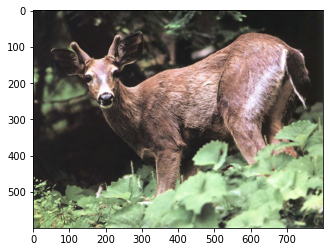

Predicted Animal: gray wolf 
 True Animal: gray_wolf


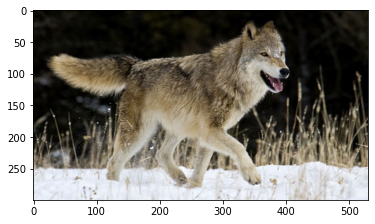

Predicted Animal: raccoon 
 True Animal: raccoon


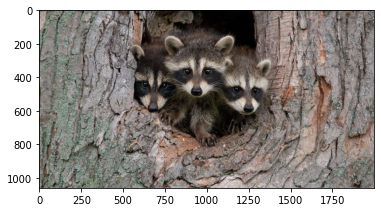

Predicted Animal: gray wolf 
 True Animal: gray_wolf


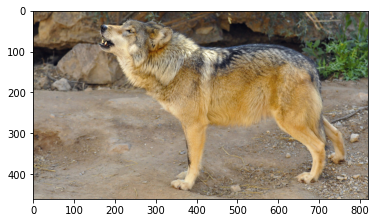

Predicted Animal: bald eagle 
 True Animal: bald_eagle


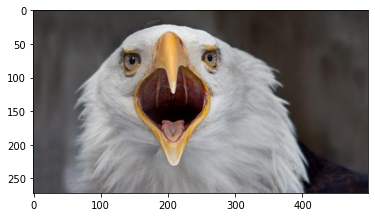

Predicted Animal: canada lynx 
 True Animal: canada_lynx


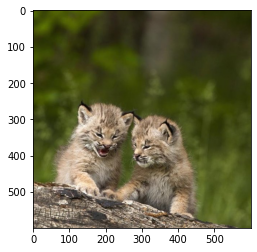

Predicted Animal: mountain beaver 
 True Animal: mountain_beaver


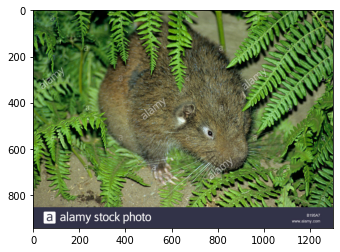

Predicted Animal: deer 
 True Animal: deer


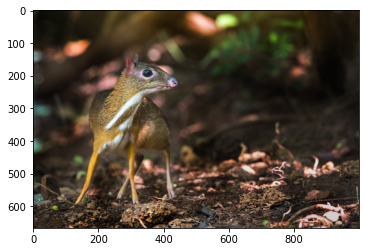

Predicted Animal: virginia opossum 
 True Animal: virginia_opossum


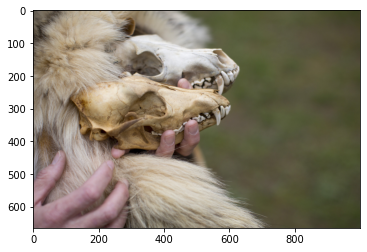

Predicted Animal: red fox 
 True Animal: red_fox


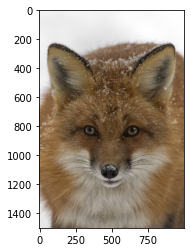

Predicted Animal: virginia opossum 
 True Animal: virginia_opossum


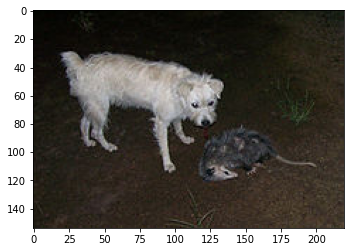

Predicted Animal: red fox 
 True Animal: red_fox


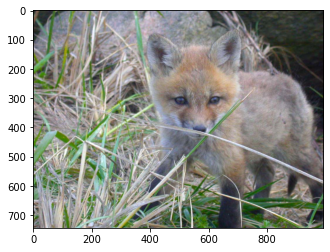

Predicted Animal: canada lynx 
 True Animal: canada_lynx


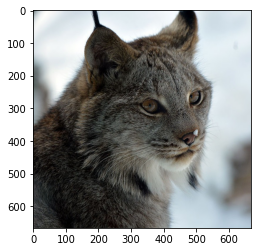

Predicted Animal: elk 
 True Animal: elk


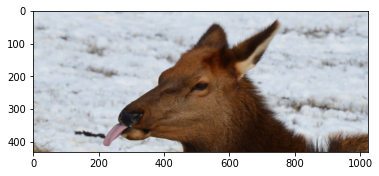

Predicted Animal: raven 
 True Animal: raven


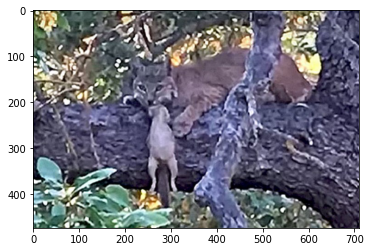

Predicted Animal: virginia opossum 
 True Animal: virginia_opossum


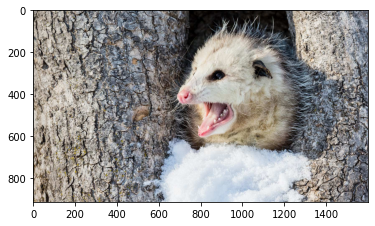

Predicted Animal: black bear 
 True Animal: black_bear


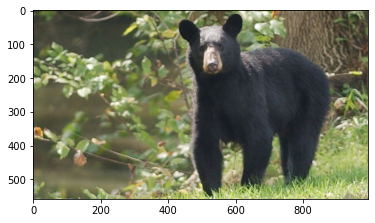

Predicted Animal: canada lynx 
 True Animal: canada_lynx


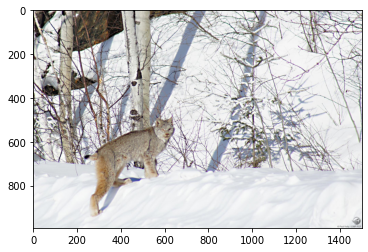

Predicted Animal: canada lynx 
 True Animal: canada_lynx


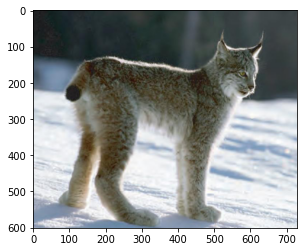

Predicted Animal: columbian black-tailed deer 
 True Animal: columbian_black-tailed_deer


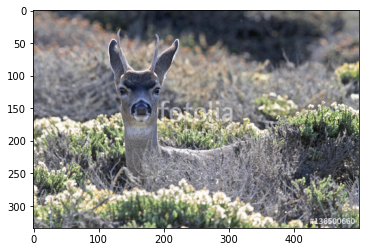

In [86]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.autograd import Variable
import random
import re

# create a list with a class names
class_names = image_datasets['train'].classes
class_names = [re.sub("\d{3}.", "", item) for item in class_names]
class_names = [re.sub("_", " ", item) for item in class_names]

def predict_breed_transfer(img_path):
    
    # load the image and return the predicted breed    
    img = Image.open(img_path) # Load the image from provided path
    
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    
    preprocess = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize]
    )
    
    img_tensor = preprocess(img).float()
    img_tensor.unsqueeze_(0)  # Insert the new axis at index 0 i.e. in front of the other axes/dims.
    img_tensor = Variable(img_tensor) #The input to the network needs to be an autograd Variable
    
    if use_cuda:
        img_tensor = Variable(img_tensor.cuda())        
    
    model_transfer.eval()
    output = model_transfer(img_tensor) # Returns a Tensor of shape (batch, num class labels)
    output = output.cpu()
    
    # Our prediction will be the index of the class label with the largest value.
    predict_index = output.data.numpy().argmax() 
    
    predicted_breed = class_names[predict_index]
    true_breed = image_datasets['train'].classes[predict_index]
    
    return (predicted_breed, true_breed)


# Create list of test image paths

test_img_paths = list(df_animals[df_animals.train_val_test == 2].file_path)
np.random.shuffle(test_img_paths)

for img_path in test_img_paths[0:20]:
    predicted_breed, true_breed = predict_breed_transfer(img_path)
    print("Predicted Animal:" , predicted_breed, "\n", "True Animal:" , true_breed)
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
